# Neural Network Dev Notebook

This notebook is for development of a suitable neural network for training on the training set. Here, I use the dev set and tune hyperparameters and model structure for best performance. 

In [40]:
import keras
import glob
import os
from PIL import Image
import pandas as pd
import numpy as np
from collections import defaultdict
from tqdm import tnrange, tqdm_notebook
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Conv2D, MaxPooling2D, ZeroPadding2D, Flatten, Lambda, BatchNormalization
from keras import backend as K
from keras.optimizers import Adam
import matplotlib
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from utils import load_json, make_logger
import logging
import itertools
import pickle
import difflib

params = load_json('params.json')
logger = make_logger('development', 'log/development.log')

## Load the dev set and images

Creates a dict relating artist MBIDs to spectrogram images, represented as 128x128x1 arrays of floats. Also load the previously saved database of artist relationships.

For now, we only load the first track we have on file for each artist, even if we have more. This can be changed later.

In [2]:
logger.info('Loading images')

images = defaultdict(list)

for path in tqdm_notebook(glob.glob('tracks/**/*.png', recursive=True)):
    mbid = os.path.basename(path).rsplit('-', 1)[0]
    img = np.array(Image.open(path).convert('L')) / 255
    img = np.reshape(img, img.shape + (1,))
    images[mbid].append(img)
    
logger.info('Loaded images')

Loading images


Loaded images


In [3]:
logger.info('Loading dev set')

raw_dataset = pd.read_hdf('dataset/dev_min.hd5', key='artists')

logger.info('Loaded dev set')

Loading dev set
Loaded dev set


In [4]:
logger.info('Artists in images: {}'.format(len(images)))
logger.info('Dataset length: {}'.format(len(raw_dataset)))

Artists in images: 9484
Dataset length: 4656


## Define accuracy metric

For my accuracy metric, I get the top similar artists for each artist from the original dataset, then to calculate accuracy of the model, I use the model to calculate all pairwise similarity scores and get the top predicted similar artists. Then I compare the two using edit distance, and return the average value as an accuracy.

Calculating accuracy like this is slow because you pretty much have to go through a full epoch. It's probably only useful at the end of training.

In [64]:
# Unstack dataframe and get top 10 similar artists for each artist, to use for accuracy metric
unstackeddf = raw_dataset.unstack(fill_value = 0)
allartists = unstackeddf.columns.union(unstackeddf.index)
unstackeddf = unstackeddf.reindex(index = allartists, columns = allartists, fill_value = 0)
unstackeddf = unstackeddf + unstackeddf.T

def similarity_matrix_to_top(matrix):
    # Converts a similarity score matrix to a sorted table of most similar artists
    most_similar = np.argsort(-matrix.values, axis=1)
    return pd.DataFrame(most_similar, index=matrix.index).T

def eval_artist_similarity(artist_A, artist_B, model):
    # Collect all pairwise combinations of artist tracks, evaluates the model on them, then
    # returns the similarity as an average of all the predictions
    audio_A = images[artist_A]
    audio_B = images[artist_B]
    
    X_tmp = [list(), list()]
    for pair in itertools.product(audio_A, audio_B):
        X_tmp[0].append(pair[0])
        X_tmp[1].append(pair[1])
    
    return np.mean(model.predict(X_tmp))

def create_similarity_matrix(artists, model):
    # Creates a similarity matrix for a list of artists, using a given model to predict similarity
    df = pd.DataFrame(np.zeros((len(artists), len(artists))), columns = artists, index = artists)
    for artist_A, artist_B in itertools.permutations(artists, 2):
        if artist_A != artist_B:
            df[artist_A][artist_B] = eval_artist_similarity(artist_A, artist_B, model)
    return df

def compare_accuracy_edit_dist(df1, df2, n=10):
    # Compares accuracy of two similarity ranking dataframes using edit distance, comparing the top n ranked
    # similar artists
    distances = dict()
    for column in df1:
        distances[column] = difflib.SequenceMatcher(None, df1.head(n)[column], df2.head(n)[column]).ratio()
    return np.mean(np.array(list(distances.values()))), distances

def compare_accuracy_unordered(df1, df2, n=10):
    # Compares accuracy of two similarity ranking dataframes by looking at the size, comparing the top n ranked
    # similar artists
    distances = dict()
    for column in df1:
        distances[column] = len(set(df1.head(n)[column].values).intersection(df2.head(n)[column].values))\
            / len(df1.head(n)[column])
    return np.mean(np.array(list(distances.values()))), distances

mostsimilardf = similarity_matrix_to_top(unstackeddf)

## Create dataset relating image references to values

Previously, we had the large raw dataset which is of the form `raw_dataset[artistA][artistB]=similarity`. Here, we create X and Y arrays, with the X array being a list of two arrays, each containing references to one of the spectrogram images that was loaded for a given artist. The Y array is a list containing the similarity scores for the corresponding two artists.

In [6]:
logger.info('Re-formatting dataset for training')

X_1 = list()
X_2 = list()
Y = list()

for index, value in tqdm_notebook(raw_dataset.iteritems(), total = len(raw_dataset)):
    artist_A = index[0]
    artist_B = index[1]
    audio_A = images[artist_A]
    audio_B = images[artist_B]
        
    for pair in itertools.product(audio_A, audio_B):
        X_1.append(pair[0])
        X_2.append(pair[1])
        Y.append(value)

Y = np.array(Y)
X = [X_1, X_2]

logger.info('Dataset formatted')

Re-formatting dataset for training


Dataset formatted


## Define Keras model specification

This defines a siamese network, which trains the same model with the same parameters and applies it to both images. The output of this shared vector is a fully-connected network with 128 neurons, for each image. The L1 distance between these two networks is then taken and the resulting 128 length vector is fed into a final sigmoid function.

In [7]:
def L1_distance(x):
    return K.abs(x[0] - x[1])

def L1_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return shape1

def create_base_network(input_shape):
    input = Input(shape = input_shape)
    x = ZeroPadding2D()(input) # 130x130x1
    x = Conv2D(8,(3,3),activation='tanh')(x) # 128x128x8
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x) # 64x64x8
    x = ZeroPadding2D()(x) # 66x66x8
    x = Conv2D(16,(3,3),activation='tanh')(x) # 64x64x16
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x) # 32x32x16
    x = ZeroPadding2D()(x) # 34x34x16
    x = Conv2D(32,(3,3),activation='tanh')(x) # 32x32x32
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x) # 16x16x32
    x = ZeroPadding2D()(x) # 18x18x32
    x = Conv2D(64,(3,3),activation='tanh')(x) # 16x16x64
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x) # 8x8x64
    x = ZeroPadding2D()(x) # 10x10x64
    x = Conv2D(128,(7,7),activation='tanh')(x) # 4x4x128
    x = Flatten()(x) # vector len 2048
    x = Dense(512, activation='tanh')(x) # FC 512
    return Model(input, x)
    
def model_spec(lr = 0.001, decay = 0.0, **kwargs):
    input_shape = (128,128,1)

    siamese_net = create_base_network(input_shape)

    input_a = Input(shape = input_shape)
    input_b = Input(shape = input_shape)

    process_a = siamese_net(input_a)
    process_b = siamese_net(input_b)

    distance = Lambda(L1_distance, output_shape = L1_dist_output_shape)([process_a, process_b])

    output = Dense(1, activation='sigmoid')(distance)

    model = Model([input_a, input_b], output)

    adam = Adam(lr=lr, decay=decay)
    model.compile(loss = 'mean_squared_error', optimizer = adam)
    
    return model

## Hyperparameter Search

This function will take in a model and a hyperparameters dict, and output training and test losses after training. The following hyperparameters are implemented:

`batch_size`: batch size for training

`epochs`: number of epochs to use in the training phase

`lr`: learning rate for model

`decay`: decay for learning rate

`expon_weight`: scale of exponential loss weighting

In [62]:
def build_model_path(hparams):
    path_components = ['_'.join([key, str(val)]) for key,val in hparams.items()]
    return os.path.join('models', *path_components)

def test_hyperparams(hparams, model_spec, log=True, save=True):
    # Make the path to the logger/model directory, named based on parameters
    path = build_model_path(hparams)
    os.makedirs(path, exist_ok=True)
    
    # Get temporary logger with hparams.__str__ name 
    tmp_logger = make_logger(str(hparams), os.path.join(path, 'training.log'), log_to_console=False)
    
    batch_size = hparams['batch_size']
    epochs = hparams['epochs']
    model = model_spec(**hparams)
    expon_weight = hparams['expon_weight']

    tmp_logger.info('Training with params {}'.format(hparams))
    
    loss_weights = np.exp(5 * np.array(Y)) / (np.sum(np.exp(5 * np.array(Y))))
    loss_weights /= np.mean(loss_weights)

    history = model.fit(X, Y, epochs=epochs, class_weight=loss_weights, batch_size=batch_size, validation_split=0.25)
    
    sim_matrix = create_similarity_matrix(allartists, model)
    edit_dist_accuracy, _ = compare_accuracy_edit_dist(similarity_matrix_to_top(sim_matrix), mostsimilardf)
    unordered_accuracy, _ = compare_accuracy_unordered(similarity_matrix_to_top(sim_matrix), mostsimilardf)

    tmp_logger.info('Edit Distance Accuracy: {:.10f}'.format(edit_dist_accuracy))
    tmp_logger.info('Unordered Accuracy: {:.10f}'.format(unordered_accuracy))
    
    tmp_logger.info('Finished training, final train loss = {:.5f}, test loss = {:.5f}'.format(
        history.history['loss'][-1], history.history['val_loss'][-1]))
    
    with open(os.path.join(path, 'history'), 'wb') as file:
        pickle.dump(history.history, file)
    
    if save:
        tmp_logger.info('Saving model')
        model.save(os.path.join(path, 'post_train_model.hd5'))
        tmp_logger.info('Saved model')
        

## Iterate through Hyperparameter sets and Evaluate

Create a dict containing all values for all hyperparameters we want to look at, then generate all combinations of these parameters and test each one.

In [13]:
all_hparams = {
    'batch_size': [64, 128, 256],
    'epochs': [5, 10, 25], 
    'lr': [0.1, 0.01, 0.001],
    'expon_weight': [0, 2.5, 5]
}

hparams_list = list()
keys, vals = zip(*all_hparams.items())
for val in itertools.product(*vals):
    hparams_list.append(dict(zip(keys, val)))

logger.info('Generated hyperparameters test list, total of {} combinations'.format(len(hparams_list)))

for hparams in tqdm_notebook(hparams_list):
    display(hparams)
    test_hyperparams(hparams, model_spec)

Generated hyperparameters test list, total of 81 combinations


{'batch_size': 64, 'epochs': 5, 'lr': 0.1, 'expon_weight': 0}

Train on 29509 samples, validate on 9837 samples
Epoch 1/5
29509/29509 [==============================] - 50s 2ms/step - loss: 0.0043 - val_loss: 0.0034
Epoch 2/5
29509/29509 [==============================] - 43s 1ms/step - loss: 0.0029 - val_loss: 0.0034
Epoch 3/5
29509/29509 [==============================] - 43s 1ms/step - loss: 0.0029 - val_loss: 0.0034
Epoch 4/5
29509/29509 [==============================] - 44s 1ms/step - loss: 0.0029 - val_loss: 0.0034
Epoch 5/5
29509/29509 [==============================] - 43s 1ms/step - loss: 0.0029 - val_loss: 0.0034


{'batch_size': 64, 'epochs': 5, 'lr': 0.1, 'expon_weight': 2.5}

Train on 29509 samples, validate on 9837 samples
Epoch 1/5
29509/29509 [==============================] - 46s 2ms/step - loss: 0.0046 - val_loss: 0.0041
Epoch 2/5
29509/29509 [==============================] - 44s 1ms/step - loss: 0.0029 - val_loss: 0.0040
Epoch 3/5
29509/29509 [==============================] - 44s 1ms/step - loss: 0.0029 - val_loss: 0.0034
Epoch 4/5
29509/29509 [==============================] - 44s 1ms/step - loss: 0.0029 - val_loss: 0.0034
Epoch 5/5
29509/29509 [==============================] - 44s 1ms/step - loss: 0.0029 - val_loss: 0.0034


{'batch_size': 64, 'epochs': 5, 'lr': 0.1, 'expon_weight': 5}

Train on 29509 samples, validate on 9837 samples
Epoch 1/5
29509/29509 [==============================] - 46s 2ms/step - loss: 0.0047 - val_loss: 0.0034
Epoch 2/5
29509/29509 [==============================] - 43s 1ms/step - loss: 0.0029 - val_loss: 0.0034
Epoch 3/5
29509/29509 [==============================] - 43s 1ms/step - loss: 0.0029 - val_loss: 0.0034
Epoch 4/5
29509/29509 [==============================] - 43s 1ms/step - loss: 0.0029 - val_loss: 0.0034
Epoch 5/5
29509/29509 [==============================] - 43s 1ms/step - loss: 0.0029 - val_loss: 0.0034


{'batch_size': 64, 'epochs': 5, 'lr': 0.01, 'expon_weight': 0}

Train on 29509 samples, validate on 9837 samples
Epoch 1/5
29509/29509 [==============================] - 46s 2ms/step - loss: 0.0067 - val_loss: 0.0051
Epoch 2/5
29509/29509 [==============================] - 44s 1ms/step - loss: 0.0051 - val_loss: 0.0044
Epoch 3/5
29509/29509 [==============================] - 44s 1ms/step - loss: 0.0045 - val_loss: 0.0041
Epoch 4/5
29509/29509 [==============================] - 44s 1ms/step - loss: 0.0039 - val_loss: 0.0042
Epoch 5/5
29509/29509 [==============================] - 44s 1ms/step - loss: 0.0031 - val_loss: 0.0034


{'batch_size': 64, 'epochs': 5, 'lr': 0.01, 'expon_weight': 2.5}

Train on 29509 samples, validate on 9837 samples
Epoch 1/5
29509/29509 [==============================] - 47s 2ms/step - loss: 0.0073 - val_loss: 0.0057
Epoch 2/5
29509/29509 [==============================] - 44s 2ms/step - loss: 0.0047 - val_loss: 0.0044
Epoch 3/5
29509/29509 [==============================] - 44s 1ms/step - loss: 0.0033 - val_loss: 0.0039
Epoch 4/5
29509/29509 [==============================] - 44s 1ms/step - loss: 0.0029 - val_loss: 0.0036
Epoch 5/5
29509/29509 [==============================] - 44s 1ms/step - loss: 0.0029 - val_loss: 0.0044


{'batch_size': 64, 'epochs': 5, 'lr': 0.01, 'expon_weight': 5}

Train on 29509 samples, validate on 9837 samples
Epoch 1/5
29509/29509 [==============================] - 47s 2ms/step - loss: 0.0063 - val_loss: 0.0071
Epoch 2/5
29509/29509 [==============================] - 44s 1ms/step - loss: 0.0048 - val_loss: 0.0060
Epoch 3/5
29509/29509 [==============================] - 44s 1ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 4/5
29509/29509 [==============================] - 44s 1ms/step - loss: 0.0030 - val_loss: 0.0034
Epoch 5/5
29509/29509 [==============================] - 44s 1ms/step - loss: 0.0030 - val_loss: 0.0034


{'batch_size': 64, 'epochs': 5, 'lr': 0.001, 'expon_weight': 0}

Train on 29509 samples, validate on 9837 samples
Epoch 1/5
29509/29509 [==============================] - 47s 2ms/step - loss: 0.0031 - val_loss: 0.0035
Epoch 2/5
29509/29509 [==============================] - 44s 2ms/step - loss: 0.0021 - val_loss: 0.0038
Epoch 3/5
29509/29509 [==============================] - 44s 2ms/step - loss: 0.0021 - val_loss: 0.0092
Epoch 4/5
29509/29509 [==============================] - 44s 2ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 5/5
29509/29509 [==============================] - 45s 2ms/step - loss: 0.0020 - val_loss: 0.0037


{'batch_size': 64, 'epochs': 5, 'lr': 0.001, 'expon_weight': 2.5}

Train on 29509 samples, validate on 9837 samples
Epoch 1/5
29509/29509 [==============================] - 48s 2ms/step - loss: 0.0040 - val_loss: 0.0031
Epoch 2/5
29509/29509 [==============================] - 44s 2ms/step - loss: 0.0020 - val_loss: 0.0078
Epoch 3/5
29509/29509 [==============================] - 44s 2ms/step - loss: 0.0019 - val_loss: 0.0091
Epoch 4/5
29509/29509 [==============================] - 44s 2ms/step - loss: 0.0020 - val_loss: 0.0031
Epoch 5/5
29509/29509 [==============================] - 44s 2ms/step - loss: 0.0020 - val_loss: 0.1532


{'batch_size': 64, 'epochs': 5, 'lr': 0.001, 'expon_weight': 5}

Train on 29509 samples, validate on 9837 samples
Epoch 1/5
29509/29509 [==============================] - 48s 2ms/step - loss: 0.0031 - val_loss: 0.0040
Epoch 2/5
29509/29509 [==============================] - 44s 1ms/step - loss: 0.0025 - val_loss: 0.0037
Epoch 3/5
29509/29509 [==============================] - 44s 2ms/step - loss: 0.0023 - val_loss: 0.0044
Epoch 4/5
29509/29509 [==============================] - 44s 1ms/step - loss: 0.0022 - val_loss: 0.0035
Epoch 5/5
29509/29509 [==============================] - 44s 1ms/step - loss: 0.0023 - val_loss: 0.0107


KeyboardInterrupt: 

## Random testing stuff below

In [30]:
hparams = {
    'batch_size': 256,
    'epochs': 10
}
#test_hyperparams(hparams, model_spec)
model = model_spec()
train_weights = np.exp(0 * np.array(Y)) / (np.sum(np.exp(0 * np.array(Y))))
train_weights /= np.mean(train_weights)
history = model.fit(X, Y, epochs=50, class_weight=train_weights, batch_size=256, validation_split=0.25)

Train on 29509 samples, validate on 9837 samples
Epoch 1/50
29509/29509 [==============================] - 46s 2ms/step - loss: 0.0057 - val_loss: 0.0036
Epoch 2/50
29509/29509 [==============================] - 41s 1ms/step - loss: 0.0021 - val_loss: 0.0028
Epoch 3/50
29509/29509 [==============================] - 42s 1ms/step - loss: 0.0014 - val_loss: 0.0029
Epoch 4/50
29509/29509 [==============================] - 42s 1ms/step - loss: 9.9412e-04 - val_loss: 0.0026
Epoch 5/50
29509/29509 [==============================] - 42s 1ms/step - loss: 7.8022e-04 - val_loss: 0.0020
Epoch 6/50
29509/29509 [==============================] - 42s 1ms/step - loss: 6.0582e-04 - val_loss: 0.0033
Epoch 7/50
29509/29509 [==============================] - 42s 1ms/step - loss: 5.3825e-04 - val_loss: 0.0021
Epoch 8/50
29509/29509 [==============================] - 42s 1ms/step - loss: 5.1209e-04 - val_loss: 0.0019
Epoch 9/50
29509/29509 [==============================] - 42s 1ms/step - loss: 5.2100e-04 -

In [ ]:
predictions = model.predict(X_test)

In [ ]:
diffs = predictions.reshape(len(predictions),) - np.array(Y_test)

In [ ]:
np.set_printoptions(suppress=True)
np.set_printoptions(threshold=np.nan)
np.sort(diffs)

In [ ]:
model.save('models/test1.hd5')

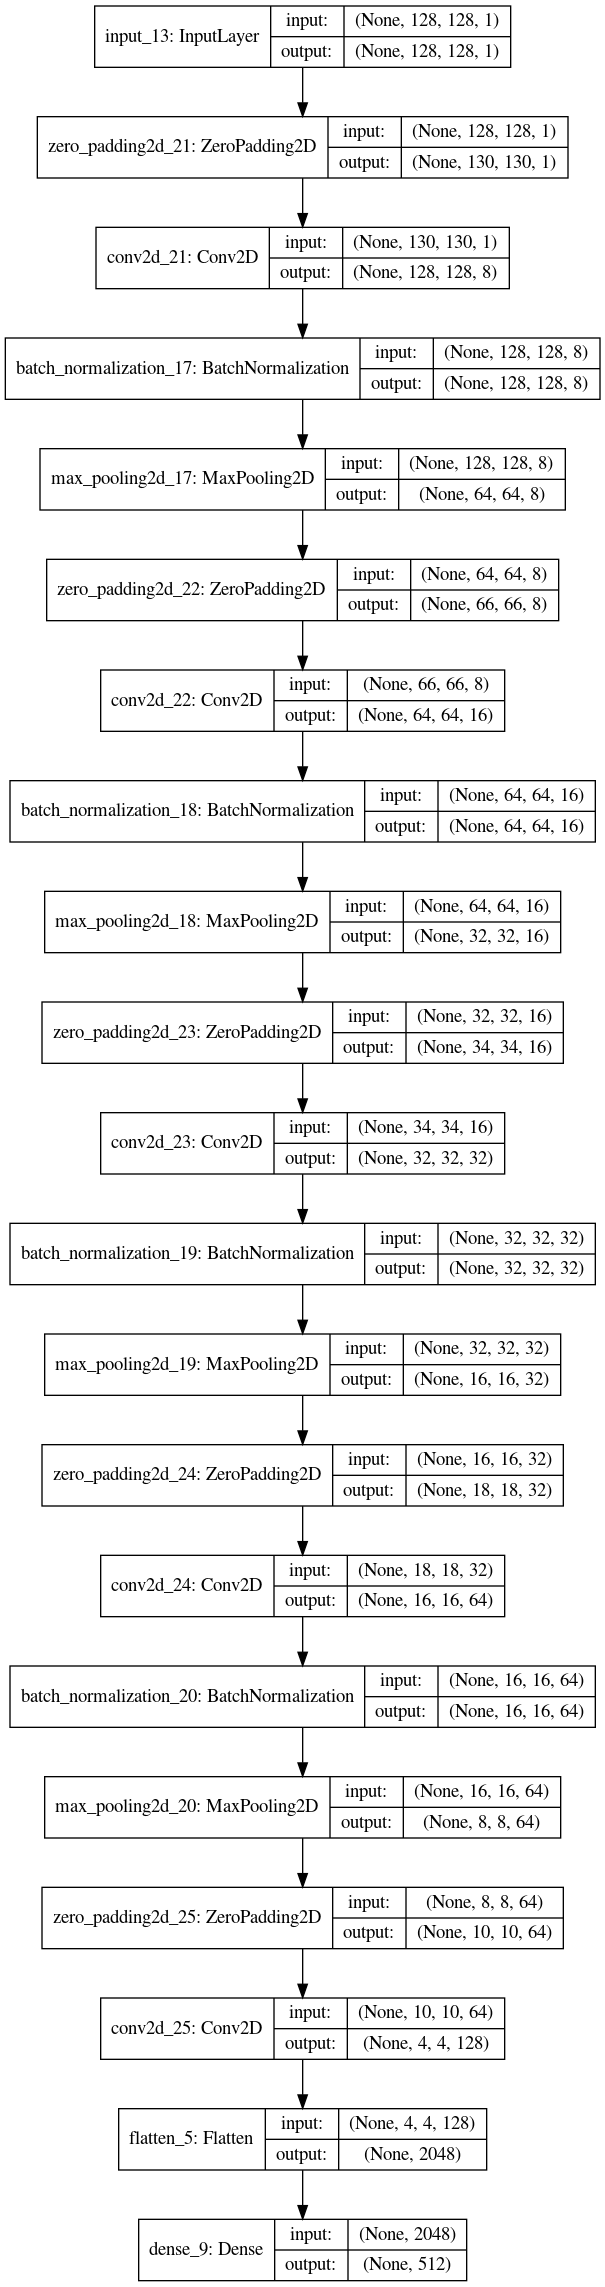

In [113]:
from keras.utils import plot_model
plot_model(model, show_shapes = True, expand_nested=True)
plot_model(create_base_network((128,128,1)), show_shapes = True, expand_nested=True)

In [87]:
def eval_artist_similarity(artist_A, artist_B, model):
    # Collect all pairwise combinations of artist tracks, evaluates the model on them, then
    # returns the average as a similarity
    audio_A = images[artist_A]
    audio_B = images[artist_B]
    
    X_tmp = [list(), list()]
    for pair in itertools.product(audio_A, audio_B):
        X_tmp[0].append(pair[0])
        X_tmp[1].append(pair[1])
    
    return np.mean(model.predict(X_tmp))

def create_similarity_matrix(artists, model):
    df = pd.DataFrame(np.zeros((len(artists), len(artists))), columns = artists, index = artists)
    for artist_A, artist_B in itertools.permutations(artists, 2):
        if artist_A != artist_B:
            df[artist_A][artist_B] = eval_artist_similarity(artist_A, artist_B, model)
    return df

sim_matrix = create_similarity_matrix(allartists, model)

In [31]:
sim_matrix = create_similarity_matrix(allartists, model)

In [80]:
def compare_accuracy_edit_dist(df1, df2, n=10):
    distances = dict()
    for column in df1:
        distances[column] = difflib.SequenceMatcher(None, df1.head(n)[column], df2.head(n)[column]).ratio()
    return np.mean(np.array(list(distances.values()))), distances

def compare_accuracy_unordered(df1, df2, n=10):
    distances = dict()
    for column in df1:
        distances[column] = len(set(df1.head(n)[column].values).intersection(df2.head(n)[column].values))\
            / len(df1.head(n)[column])
    return np.mean(np.array(list(distances.values()))), distances

accuracy, distances = compare_accuracy_edit_dist(similarity_matrix_to_top(sim_matrix), mostsimilardf)
accuracy

0.5731958762886598

In [38]:
similarity_matrix_to_top(sim_matrix)

,0039c7ae-e1a7-4a7d-9b49-0cbc716821a6,013fa897-86db-41d3-8e9f-386c8a34f4e6,01809552-4f87-45b0-afff-2c6f0730a3be,0741b30d-e15b-4a8c-b2e5-8834a03d6116,07eb40a2-2914-439c-a01d-15a685b84ddf,09885b8e-f235-4b80-a02a-055539493173,0ef3f425-9bd2-4216-9dd2-219d2fe90f1f,10bf95b6-30e3-44f1-817f-45762cdc0de0,11c6b106-1c1f-429d-8407-b1ee155d7f72,12d432a3-feb0-49b1-a107-d20751880764,...,db4624cf-0e44-481e-a9dc-2142b833ec2f,db76c5ca-d555-4f09-b1db-baa1b713d875,de11b037-d880-40e0-8901-0397c768c457,e0953daa-860f-4dc8-9f1a-b12587cdaf17,e5c7b94f-e264-473c-bb0f-37c85d4d5c70,e618770f-e994-41c3-856f-1eedf56b6d74,e6e879c0-3d56-4f12-b3c5-3ce459661a8e,eab76c9f-ff91-4431-b6dd-3b976c598020,f83781c8-64f9-4657-85bd-51f74d195cfd,fa927f59-d443-418a-b741-e557208aaf09
0,91,91,85,61,42,73,32,27,49,15,...,50,66,64,21,0,24,15,10,84,36
1,26,85,75,43,48,24,87,33,68,84,...,75,56,3,64,26,5,84,35,79,79
2,15,61,32,26,68,30,57,45,42,79,...,6,49,43,82,1,38,19,76,21,21
3,57,93,50,89,8,46,50,80,19,18,...,32,25,61,26,85,53,13,80,26,0
4,38,0,87,82,23,38,17,51,89,91,...,2,60,23,40,79,61,1,79,91,26
5,79,79,57,72,58,11,44,39,57,20,...,70,50,83,91,84,57,91,81,72,61
6,85,36,91,0,89,17,83,71,40,36,...,28,76,8,48,15,30,85,44,36,77
7,84,15,76,36,1,12,28,37,3,93,...,25,28,54,79,82,22,0,67,61,1
8,24,2,40,77,91,29,25,47,84,19,...,57,6,57,95,19,77,26,60,3,84
9,77,26,1,95,65,28,75,52,76,21,...,24,87,85,84,2,42,40,37,1,93


In [39]:
mostsimilardf

,0039c7ae-e1a7-4a7d-9b49-0cbc716821a6,013fa897-86db-41d3-8e9f-386c8a34f4e6,01809552-4f87-45b0-afff-2c6f0730a3be,0741b30d-e15b-4a8c-b2e5-8834a03d6116,07eb40a2-2914-439c-a01d-15a685b84ddf,09885b8e-f235-4b80-a02a-055539493173,0ef3f425-9bd2-4216-9dd2-219d2fe90f1f,10bf95b6-30e3-44f1-817f-45762cdc0de0,11c6b106-1c1f-429d-8407-b1ee155d7f72,12d432a3-feb0-49b1-a107-d20751880764,...,db4624cf-0e44-481e-a9dc-2142b833ec2f,db76c5ca-d555-4f09-b1db-baa1b713d875,de11b037-d880-40e0-8901-0397c768c457,e0953daa-860f-4dc8-9f1a-b12587cdaf17,e5c7b94f-e264-473c-bb0f-37c85d4d5c70,e618770f-e994-41c3-856f-1eedf56b6d74,e6e879c0-3d56-4f12-b3c5-3ce459661a8e,eab76c9f-ff91-4431-b6dd-3b976c598020,f83781c8-64f9-4657-85bd-51f74d195cfd,fa927f59-d443-418a-b741-e557208aaf09
0,91,91,85,61,42,73,87,27,49,15,...,50,66,64,21,0,25,15,10,84,21
1,26,85,32,26,1,30,32,80,31,84,...,75,56,3,26,26,50,84,35,79,36
2,15,79,75,43,43,38,57,33,76,18,...,6,25,61,82,1,62,19,67,36,0
3,38,93,87,89,8,46,50,45,60,19,...,32,49,43,64,85,5,1,76,61,79
4,57,61,50,0,85,24,17,51,42,21,...,2,60,54,40,79,61,13,79,91,26
5,30,36,19,77,23,22,31,39,40,72,...,25,50,85,48,15,24,91,80,26,1
6,85,19,57,95,2,11,44,47,48,91,...,70,6,95,91,84,31,26,31,72,84
7,84,0,40,84,58,17,75,37,89,36,...,24,19,8,95,82,79,0,81,21,77
8,24,2,76,36,20,12,2,71,20,79,...,28,28,81,84,19,73,85,44,68,91
9,77,15,1,93,89,29,60,81,84,20,...,17,76,83,96,93,87,40,37,77,93
